In [1]:
import csv
from collections import Counter
import numpy as np

file_path = '../../../NYPD_Motor_Vehicle_Collisions.csv'
#def read_data_file(file_path):
infile = open(file_path)    # open the file for reading
reader = csv.DictReader(infile, delimiter=',', skipinitialspace=True)
intersection_related_data = {}
data = []
for i,line in enumerate(reader):
    # assign the various fields in the line to variables
    accident = {}
    accident["date"] = line['DATE']
    accident["time"] = line['TIME']
    accident["lat"] = eval(line['LATITUDE']) if line['LATITUDE'] != '' else None 
    accident["lon"] = eval(line['LONGITUDE']) if line['LONGITUDE'] != '' else None
    accident["killed"] = line['NUMBER OF PERSONS KILLED']
    accident["injured"] = line['NUMBER OF PERSONS INJURED']
    accident["borough"] = line['BOROUGH']
    street = line['ON STREET NAME']
    cross_street = line['CROSS STREET NAME']
    if street and cross_street:
        if street >= cross_street:
            accident["intersection"] = street + " and " + cross_street
        else:
            accident["intersection"] = cross_street + " and " + street
        if accident["intersection"] in intersection_related_data:
            intersection_related_data[accident["intersection"]]["killed"] += int(accident["killed"])
            intersection_related_data[accident["intersection"]]["injured"] += int(accident["injured"])
        else:
            intersection_related_data[accident["intersection"]] = {
                "borough": accident["borough"],
                "killed": int(accident["killed"]),
                "injured": int(accident["injured"])
            }
        
    else:
        accident["intersection"] = ""
    data.append(accident)


In [3]:
print data[0]

{'injured': '0', 'lon': -73.9387929, 'lat': 40.8082795, 'time': '0:45', 'date': '03/14/2016', 'killed': '0'}


In [12]:
intersections = map(lambda a: a["intersection"], data)
intersections = filter(None, intersections)
c = Counter(intersections)

intersections = c.most_common()[0:100]

with open('intersections.txt', 'w') as outputFile:
    outputFile.write('intersection,borough,accidents,killed,injured\n')
    for item in intersections:
        outFile.write('"{}","{}",{},{},{}\n'.format(
                item[0],
                intersection_related_data[item[0]]['borough'],
                item[1],
                intersection_related_data[item[0]]['killed'],
                intersection_related_data[item[0]]['injured'],
            ))

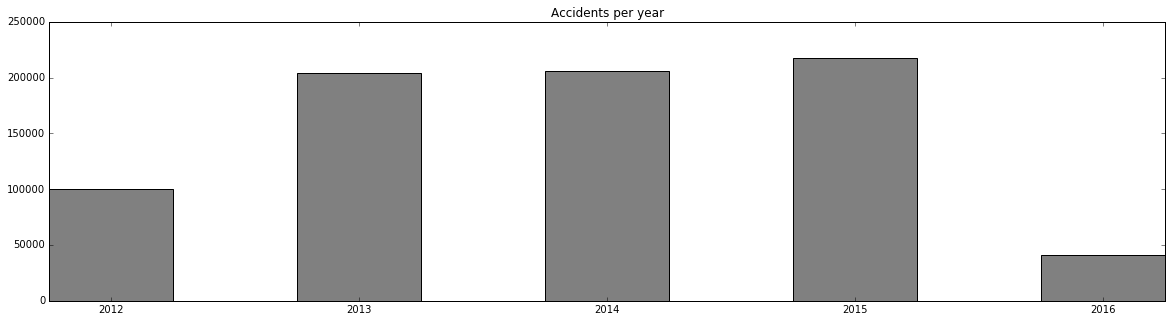

In [2]:
year_cnt = [x['date'].split('/')[-1] for x in data ]

years = Counter(year_cnt)
years = sorted(years.items())

import matplotlib.pyplot as plt
%matplotlib inline

values = [a[1] for a in years]
labels = [a[0] for a in years]

indexes = np.arange(len(labels))
width = 0.5
plt.gcf().set_size_inches(20, 5)
plt.bar(indexes, values, width,color='gray')
plt.xticks(indexes + width * 0.5, labels)
plt.title('Accidents per year')
plt.show()

In [3]:
import geoplotlib
from geoplotlib.utils import BoundingBox
#                                   
geoplotlib.set_bbox(BoundingBox(north=37.8, west=-70.5, south=37.7, east=-70.3))
                                #40.4774, west=-74.2589, south=40.9176, east=-73.7004

#geoplotlib.show()

The data is 142MB in size, has 28 columns and 769054 rows.

In [4]:
from sklearn.cluster import KMeans 
from scipy.cluster.vq import vq, whiten

Lat = [x['lat'] for x in data]
Lon = [x['lon'] for x in data]

features = zip(Lon,Lat)
features = filter(lambda x: x[0] is not None and x[1] is not None ,features)
sqrd_err = []
for k in range(2,10):
    KM = KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=300,
                            tol=0.0001, precompute_distances='auto', verbose=0, random_state=None,
                            copy_x=True, n_jobs=1)
    KM.fit(features)
    sqrd_err.append(KM.inertia_)

[5034.4850281881363, 3344.8631169664613, 2347.6001430566203, 1599.996018063855, 1303.4128144705317, 1121.4027172253107, 961.08316504131653, 865.09091783138092]


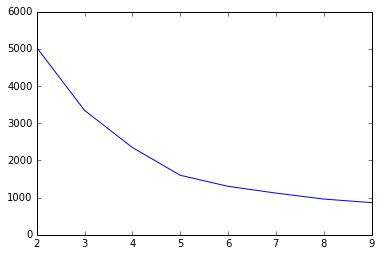

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
print sqrd_err
plt.plot(range(2,10), sqrd_err)
#plt.axis([2, 8, 0, 5])
plt.show()

4 seams to be the right amount of clusters

In [6]:
KM = [0]*3
for i in range(0,3):
    KM[i] = KMeans(n_clusters=i+3, init='k-means++', n_init=10, max_iter=300,
                            tol=0.0001, precompute_distances='auto', verbose=0, random_state=None,
                            copy_x=True, n_jobs=1)
    KM[i].fit(features)

In [7]:
np_features = np.array(features)
min_lat = np_features[:, 1].min()
max_lat = np_features[:, 1].max()
min_lon = np_features[:, 0].min()
max_lon = np_features[:, 0].max()

print min_lat
print max_lat
print min_lon
print max_lon

40.4989488
40.9128276
-74.2545316
-73.7005968


[[0 0 0 ..., 2 2 2]
 [0 0 0 ..., 2 2 2]
 [0 0 0 ..., 2 2 2]
 ..., 
 [3 3 3 ..., 1 1 1]
 [3 3 3 ..., 1 1 1]
 [3 3 3 ..., 1 1 1]]


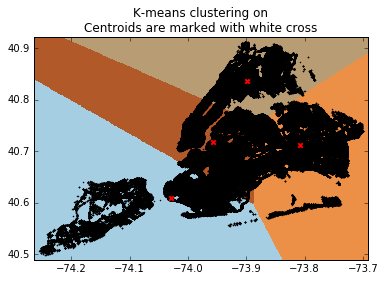

In [8]:
ep = 0.01
x_min, x_max = min_lon - ep, max_lon + ep
y_min, y_max = min_lat - ep, max_lat + ep
h=0.001
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
Z = KM[1].predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

print Z

plt.figure(1)
plt.clf()
plt.imshow(Z, interpolation='nearest',
           extent=(xx.min(), xx.max(), yy.min(), yy.max()),
           cmap=plt.cm.Paired,
           aspect='auto', origin='lower')

plt.plot(np_features[:, 0], np_features[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = KM[1].cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x',  linewidths=2,
            color='r', zorder=10)
plt.title('K-means clustering on\n'
          'Centroids are marked with white cross')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.show()

In [108]:
accidentsCSV = []
centersCSV = []
clusterPerPoint = []
for i in range(0,3):
    clusterPerPoint.append(KM[i].predict(features))
    print i
    cntAccXclust = Counter(clusterPerPoint[i])
    centersCSV.append([[KM[i].cluster_centers_[d[0]][1],KM[i].cluster_centers_[d[0]][0],d[1]] for d in cntAccXclust.items()])
    
print centersCSV

allAccidentsCSV = [[clusterPerPoint[0][j],clusterPerPoint[1][j],clusterPerPoint[2][j],f[1],f[0]] for j,f in enumerate(features)]

0
1
2
[[[40.794958486801917, -73.930114394000299, 252234], [40.709752880757257, -73.813943870898626, 153479], [40.655697164168977, -73.988055837529117, 242154]], [[40.711315555934611, -73.807925397197181, 142214], [40.717681400473268, -73.957319826480244, 284550], [40.607821968553786, -74.030458486322985, 96150], [40.835952943272588, -73.898893396615449, 124953]], [[40.74748418705277, -73.96518348505181, 202057], [40.713293129017259, -73.80713443970501, 140509], [40.648240563672537, -73.954220777743259, 165593], [40.589559637431378, -74.130342845340394, 31698], [40.842614469167252, -73.892912188699228, 108010]]]


In [115]:
import csv

for i in range(0,3):

    with open("centers"+str(3+i)+".csv", "wb") as f:
        writer = csv.writer(f)
        writer.writerows([["Latitude","Longitude","count"]])
        writer.writerows(centersCSV[i])
with open("allcenters.csv", "wb") as f:
    writer = csv.writer(f)
    writer.writerows([["cluster3","cluster4","cluster5","Latitude","Longitude"]])
    sample = random.sample(allAccidentsCSV, 10000)
    writer.writerows(sample)